# Quinoa Seed Analysis Tutorial

This is a full workflow that shows methods for counting and analyzing the shape and color of seeds. Similar methods should work for other types of seeds.

# Section 1: Importing libraries and image

In [34]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib widget

In [35]:
#Import libraries

import os
import argparse
import matplotlib
import cv2
import numpy as np

from plantcv import plantcv as pcv

## Input variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [36]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

class options:
    def __init__(self):        
        self.image = "./quinoa_seeds.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "seed_analysis_results"
        self.outdir = "."

In [37]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

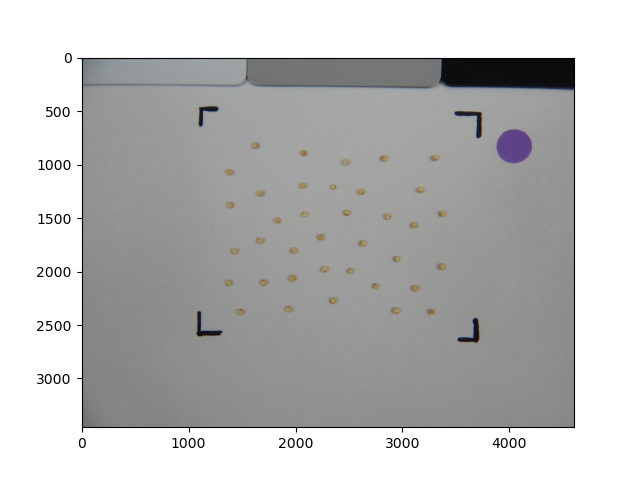

In [38]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Segmenting plant from background and identifying plant object(s)

* Requires successful import of image
* See Threshold Tools Tutorial tutorial for other functions that can be used to create a binary mask

## Crop image

Cropping out aspects of the image that may interfere with the binary mask makes it easier to isolate plant material from background. This is also useful to save memory in these tutorials. 

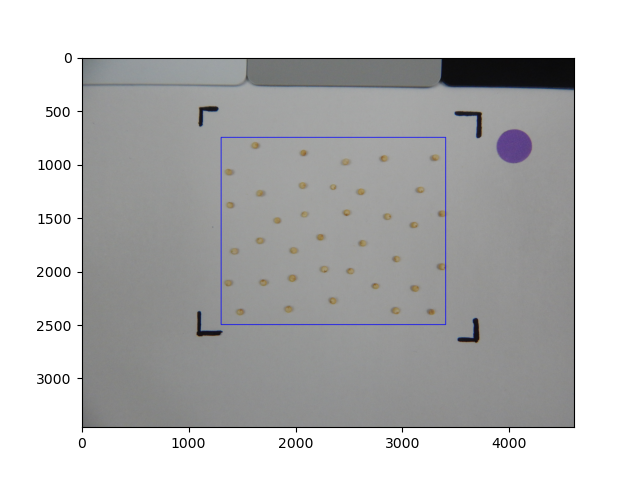

In [39]:
# Inputs:
#   x = top left x-coordinate
#   y = top left y-coordinate
#   h = height of final cropped image
#   w = width of final cropped image
img = pcv.crop(img=img, x=1300, y=750, h=1750, w=2100)

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

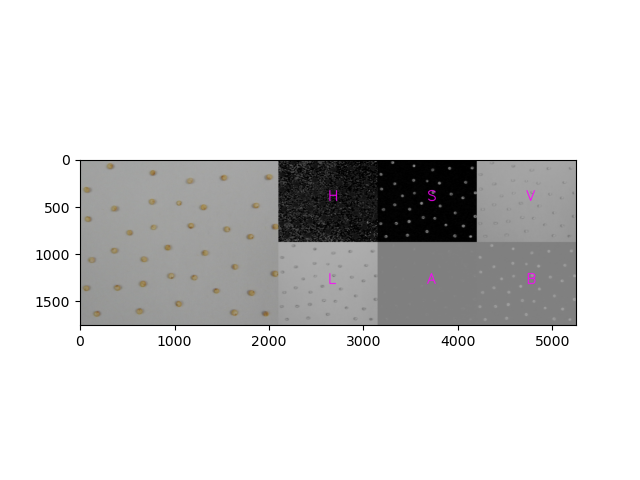

In [40]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

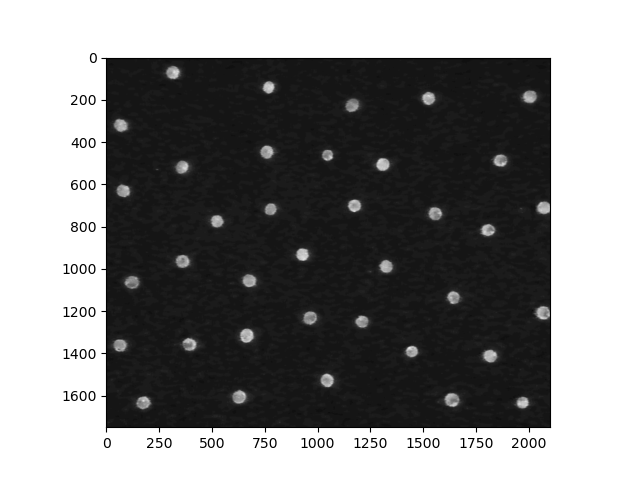

In [41]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
b_img = pcv.rgb2gray_lab(rgb_img=img, channel='b')

#Channel B is used because it provides the best separation of seeds from background.

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 125-130 are from the darker background pixels. The smaller peak between 150-160 are the lighter seed pixels.

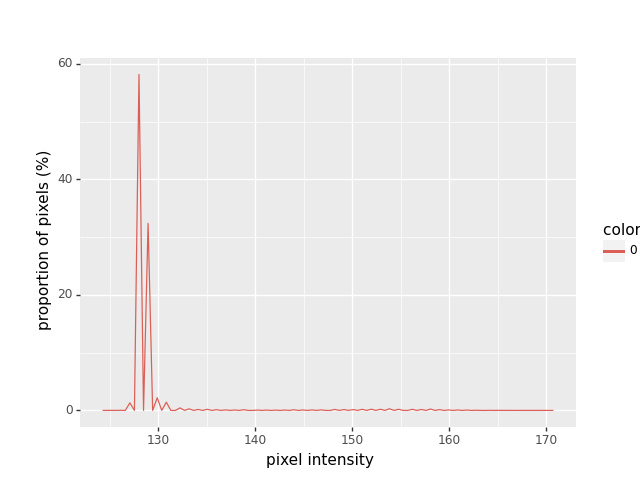

In [42]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=b_img)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 130-150 will segment the plant and background peaks. Because the seeds are the lighter pixels in this image, use object_type="light" to do a traditional threshold.

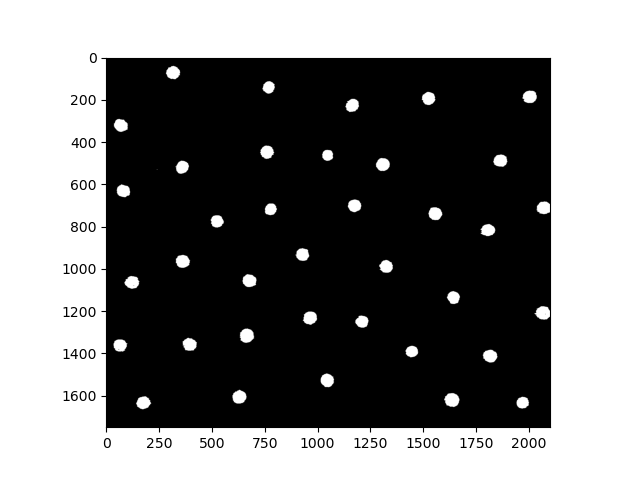

In [43]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background.
b_thresh = pcv.threshold.binary(gray_img=b_img, threshold=140, object_type='light') 

## Remove small background noise

Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size.

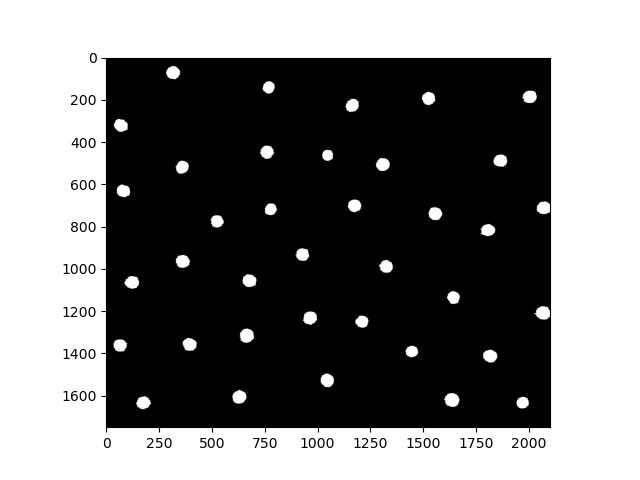

In [44]:
# Inputs:
#   bin_img - binary mask image
#   size - maximum size for objects that should be filled in as background (non-plant) pixels
b_fill = pcv.fill(bin_img=b_thresh, size=300)
#                                         ^
#                                         |
#                                 change this value

# Section 3: Count and Analyze Seeds

* Need a completed binary mask

## Count seeds

Count the number of seeds (simple objects) by accessing the number of values stores in the second item of the object list.

## Measure each seed

1. Create labeled mask
2. Analyze seed shape
3. Analyze seed color

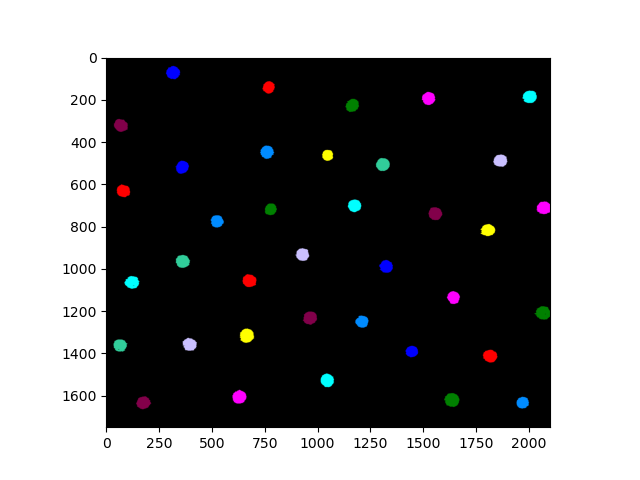

In [46]:
#Labeled mask is the mask which labels each individual seed to allow it to be measured.

        #Inputs:
        #Mask = mask created earlier in workflow

labeled_mask, num = pcv.create_labels(mask=b_fill)

In [ ]:
#Find number of objects in image. Num=number of seeds captured in image.

print (num)

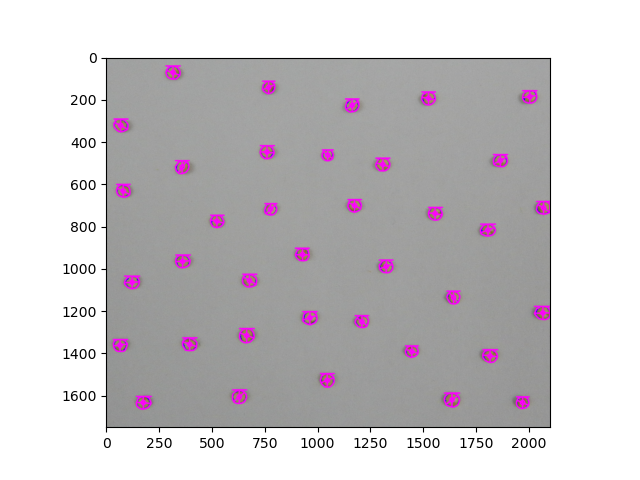

In [47]:
        # Analyze shape and size perameters of each seed
        #
        # Inputs:
        #   img = rgb image
        #   mask = mask which has labeled each individual seed in image
        #   label = how many labels based on number of seeds in image. Num->all seeds in image
shape_img = pcv.analyze.size(img=img, labeled_mask=labeled_mask, n_labels=num)

In [48]:
        # Analyze color of each seed
        #
        # Inputs:
        #   img = rgb image
        #   labeled_mask = labeled mask
        #   hist_plot_type = 'hsv', or None for no histogram plot
        #   n_labels = 'num' 

analysis_image = pcv.analyze.color(rgb_img=img, labeled_mask=labeled_mask, n_labels=num, colorspaces='hsv')

alt.FacetChart(...)

## Visualize shape analysis of seeds

Since debugging was turned off during the for loop, as plotting all analysis results significantly slows down the analysis, we can plot the final shape and color analyses to ensure that the results look correct.

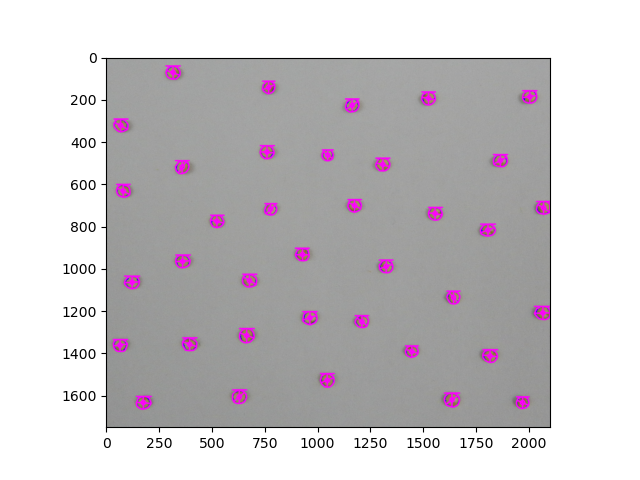

In [49]:
# Inputs:
#   img = image for shape analysis
pcv.plot_image(img=shape_img)

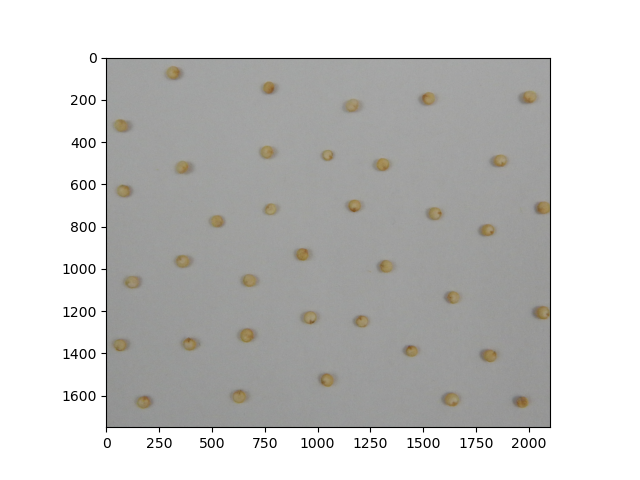

In [51]:
# Inputs:
#   img = image for color analysis
pcv.plot_image(img=img)

## Save results

During analysis, measurements are stored in the background in the outputs recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object and color analysis using analyze_color.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [21]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result, outformat="csv")